In [22]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
import scipy.stats as stats
import seaborn as sns
from functools import partial
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold

In [2]:
orig_data = pd.read_csv('saratoga-house-prices.csv')
orig_data.head(5)

,Price,Size,Baths,Bedrooms,Fireplace,Acres,Age
0,142.212,1.982,1.0,3,0,2.00,133
1,134.865,1.676,1.5,3,1,0.38,14
2,118.007,1.694,2.0,3,1,0.96,15
3,138.297,1.800,1.0,2,1,0.48,49
4,129.470,2.088,1.0,3,1,1.84,29


In this dataset, we have prices of houses (in dollars per sq. ft) made available along with the some properties of the house like area, number of bedrooms, age of house, etc. The goal is to create a model for the price as a function of those properties.

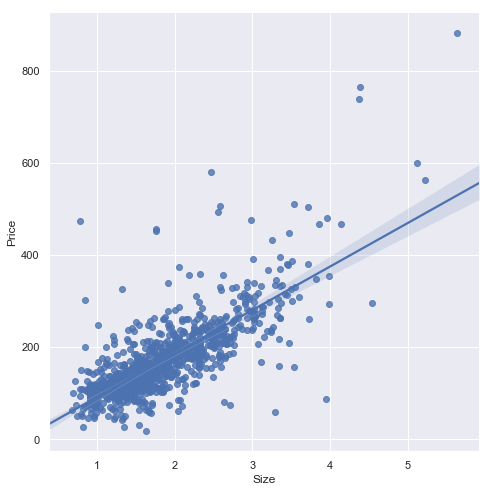

In [95]:
sns.set(color_codes=True)
filtered_df = orig_data
sns.lmplot(x="Size", y="Price", height=7, data=filtered_df);

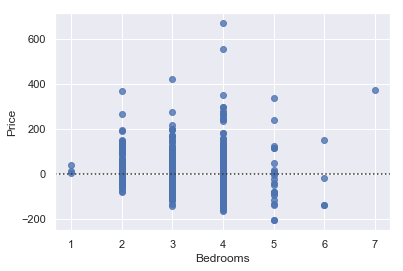

In [96]:
sns.residplot(x="Bedrooms", y="Price", data=filtered_df);

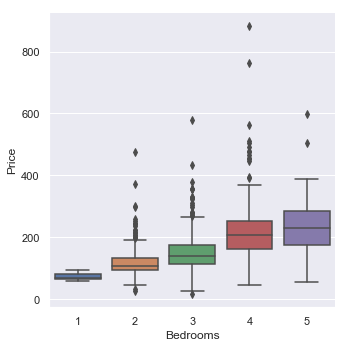

In [5]:
sns.catplot(x="Bedrooms", y="Price", kind="box", data=filtered_df);

In [6]:
x = filtered_df["Age"]
y = filtered_df["Price"]
np.corrcoef(x, y)[0][1]

-0.2929298425894244

In [89]:
def get_all_X_columns(df):
    return df[["Size", "Baths", "Bedrooms", "Fireplace", "Acres", "Age"]]

def get_X_columns(df):
    return df[["Size", "Baths"]]

def get_Y_column(df):
    return df["Price"]

In [8]:
def get_XY(data, X_columns_func=get_all_X_columns):
    X = X_columns_func(data).values
    Y = get_Y_column(data).values
    return X, Y

In [9]:
def get_model(X_train, Y_train):
    model = LinearRegression()
    model.fit(X_train, Y_train)
    return model

In [10]:
def get_errors(Y_train, Y_train_pred, Y_test, Y_test_pred):    
    training_rmse = math.sqrt(mean_squared_error(Y_train_pred, Y_train))
    test_rmse = math.sqrt(mean_squared_error(Y_test_pred, Y_test))
    training_rsq = r2_score(Y_train_pred, Y_train)
    test_rsq = r2_score(Y_test_pred, Y_test)
    return training_rmse, test_rmse, training_rsq, test_rsq

In [11]:
def plot_feature_weights(coef, X_columns_func=get_all_X_columns):
    features = X_columns_func(orig_data).columns.values
    weights = coef
    plt.bar(features, weights)
    for a,b in zip(features, weights):
        plt.text(a, b, "{0:.2f}".format(b))
    plt.show()

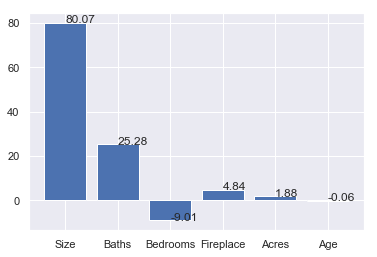

In [97]:
## Fitting attempt 1
X_train, Y_train = get_XY(filtered_df)
model = get_model(X_train, Y_train)
plot_feature_weights(model.coef_)
orig_data['predicted']=model.predict(get_all_X_columns(orig_data))
orig_data['residual']=orig_data['predicted'] - get_Y_column(orig_data)

[1555.90952864  862.06371489  300.86288274  213.73979753   35.29273533
   77.82138942] [3.21148090e-210 3.51619670e-139 1.58374267e-059 3.09474466e-044
 3.84208920e-009 4.55578507e-018]


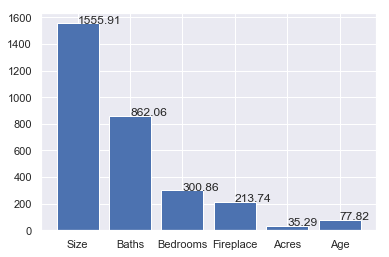

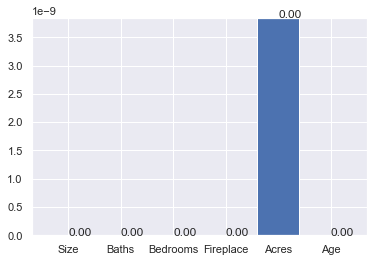

In [98]:
f, p = f_regression(X_train, Y_train, center=True)
print (f, p)
plot_feature_weights(f)
plot_feature_weights(p)

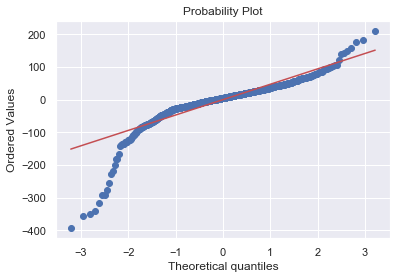

In [14]:
# Q-Q Plot
stats.probplot(orig_data['residual'], dist="norm", plot=pylab)
pylab.show()

The above Q-Q plot implies that there are outliers in the data, both in the negative side (y_actual is much less than y_pred) and on the positive side (y_actual is much higher than y_pred).

In [15]:
orig_data[(orig_data.residual < -200) | (orig_data.residual > 150)]

,Price,Size,Baths,Bedrooms,Fireplace,Acres,Age,predicted,residual
102,59.003,3.285,2.0,5,0,0.42,233,241.494172,182.491172
375,300.931,0.847,1.0,2,0,0.55,78,72.721310,-228.209690
408,738.919,4.372,5.0,7,1,0.68,144,390.089185,-348.829815
421,763.931,4.390,3.5,4,1,0.40,2,407.035566,-356.895434
422,882.341,5.632,5.5,4,1,5.88,2,565.483121,-316.857879
429,476.301,2.986,2.5,4,1,2.37,12,276.067071,-200.233929
545,155.713,3.535,3.0,4,1,4.20,39,332.994523,177.281523
649,74.422,2.708,2.0,4,0,1.20,21,232.981168,158.559168
723,473.938,0.780,1.5,2,0,0.19,55,79.771732,-394.166268
725,578.856,2.472,2.5,3,1,0.00,6,238.950355,-339.905645


In [54]:
def cross_validate_error(model_builder):
    sum_train_error = 0
    sum_test_error = 0
    sum_train_rsq = 0
    sum_test_rsq = 0

    splits = 5
    kf = KFold(n_splits=splits)
    for train_indices, test_indices in kf.split(orig_data):
        data_train = orig_data.iloc[train_indices]
        data_test = orig_data.iloc[test_indices]
        #print ("Training, test data shape:", data_train.shape, data_test.shape)
    
        X_data_train, Y_data_train = get_XY(data_train, get_X_columns)
        model = model_builder(X_data_train, Y_data_train)
        #plot_feature_weights(model.coef_, get_X_columns)
    
        X_train, Y_train = get_XY(data_train, get_X_columns)
        X_test, Y_test = get_XY(data_test, get_X_columns)
        Y_train_pred, Y_test_pred = model.predict(X_train), model.predict(X_test)
        training_rmse, test_rmse, training_rsq, test_rsq = \
        get_errors(Y_train, Y_train_pred, Y_test, Y_test_pred)
    
        sum_train_error += training_rmse
        sum_test_error += test_rmse
        sum_train_rsq += training_rsq
        sum_test_rsq += test_rsq   

    #print(sum_train_error/splits, sum_test_error/splits, sum_train_rsq/splits, sum_test_rsq/splits)
    return (sum_test_error/splits)

In [37]:
cross_validate_error(get_model)

52.607323591074284

In [59]:
def get_ridge_model(X_train, Y_train, alpha):
    #print ("Ridge model with alpha: ", alpha)
    model = Ridge(alpha=alpha)
    model.fit(X_train, Y_train)
    return model

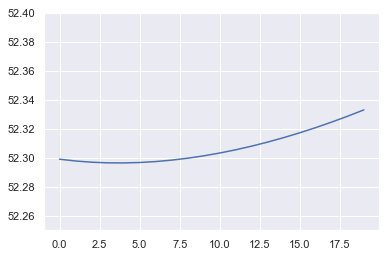

In [94]:
plt.plot([x for x in range(0, 20)], [cross_validate_error(partial(get_ridge_model, alpha=y)) for y in range(0, 20)])
plt.ylim(ymin=52.25, ymax=52.4)
plt.show()

In [79]:
def get_lasso_model(X_train, Y_train, alpha):
    #print ("Ridge model with alpha: ", alpha)
    model = Ridge(alpha=alpha)
    model.fit(X_train, Y_train)
    return model

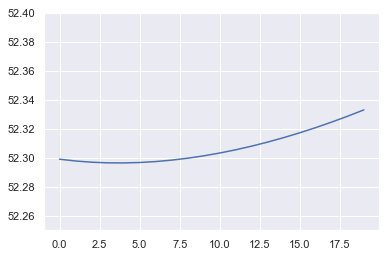

In [93]:
plt.plot([x for x in range(0, 20)], [cross_validate_error(partial(get_lasso_model, alpha=y)) for y in range(0, 20)])
plt.ylim(ymin=52.25, ymax=52.4)
plt.show()